In [1]:
import pandas as pd
import numpy as np
import openpyxl
from openpyxl import load_workbook
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
from plotly.subplots import make_subplots
from datetime import datetime
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import os
# import torch

In [2]:
# Define new column names
new_column_names = [
    'Time', 'Hip x', 'Hip y', 'Hip likelihood',
    'Knee x', 'Knee y', 'Knee likelihood',
    'Ankle x', 'Ankle y', 'Ankle likelihood',
    'Heel (ventral) x', 'Heel (ventral) y', 'Heel (ventral) likelihood',
    'Instep (dorsal) x', 'Instep (dorsal) y', 'Instep (dorsal) likelihood',
    'Toe 1 (Proximal Thumb) x', 'Toe 1 (Proximal Thumb) y', 'Toe 1 (Proximal Thumb) likelihood',
    'Toe2 x', 'Toe2 y', 'Toe2 likelihood',
    'Toe 3 (Middle) x', 'Toe 3 (Middle) y', 'Toe 3 (Middle) likelihood',
    'Toe4 x', 'Toe4 y', 'Toe4 likelihood',
    'Toe 5 (Distal Pinky) x', 'Toe 5 (Distal Pinky) y', 'Toe 5 (Distal Pinky) likelihood',
]

# Function to process each file to have the right column names and normalize the x and y coordinates
def process_file(file_path):
    # Read only the first row to check column names
    df_header = pd.read_csv(file_path, nrows=0)
    
    # Check if the existing column names match the desired new column names
    if list(df_header.columns) != new_column_names:
        # If they don't match, read the file skipping metadata and assign new column names
        df = pd.read_csv(file_path, skiprows=3, header=None)
        df.columns = new_column_names
    else:
        # If they match, read the file normally
        df = pd.read_csv(file_path)
    
    # Further processing such as interpolating NA values and resetting index
    # df.dropna(inplace=True)
    df.interpolate(method='linear', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Remove rows with any zero values in coordinate columns
    coordinate_columns = [col for col in df.columns if ' x' in col or ' y' in col]
    df = df[(df[coordinate_columns] != 0).all(axis=1)]

    # Normalize the x and y coordinates
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()
    # coordinate_columns = [col for col in df.columns if ' x' in col or ' y' in col]
    df[coordinate_columns] = scaler.fit_transform(df[coordinate_columns])
    
    # Extract x and y coordinates
    x_columns = [col for col in df.columns if ' x' in col]  
    y_columns = [col for col in df.columns if ' y' in col]

    # Create dataframes for x and y coordinates
    x_df = df[x_columns]
    y_df = df[y_columns]
    return x_df, y_df, df

In [3]:
## Process each file

# Batch 1
x_df_batch1_9ksa, y_df_batch1_9ksa, df_batch1_9ksa= process_file('/Users/joshwoah/Documents/University of Toronto/Postdoc Research/GitHub Postdoc/After tracking results/batch_1_csv/9_kSa_3p3_V_-340mV_offsetDLC_resnet50_ece2500yJan17shuffle1_100000_filtered.csv')
x_df_batch1_30ksa, y_df_batch1_30ksa, df_batch1_30ksa = process_file('/Users/joshwoah/Documents/University of Toronto/Postdoc Research/GitHub Postdoc/After tracking results/batch_1_csv/30_kSa_3p3_V_-340mV_offsetDLC_resnet50_ece2500yJan17shuffle1_100000_filtered.csv')
x_df_batch1_90ksa, y_df_batch1_90ksa, df_batch1_90ksa = process_file('/Users/joshwoah/Documents/University of Toronto/Postdoc Research/GitHub Postdoc/After tracking results/batch_1_csv/90_kSa_3p3_V_-340mV_offsetDLC_resnet50_ece2500yJan17shuffle1_100000_filtered.csv')
x_df_batch1_120ksa, y_df_batch1_120ksa, df_batch1_120ksa = process_file('/Users/joshwoah/Documents/University of Toronto/Postdoc Research/GitHub Postdoc/After tracking results/batch_1_csv/120_kSa_3p3_V_-340mV_offsetDLC_resnet50_ece2500yJan17shuffle1_100000_filtered.csv')

# Batch 2
x_df_batch2_0kHz, y_df_batch2_0kHz, df_batch2_0kHz = process_file('/Users/joshwoah/Documents/University of Toronto/Postdoc Research/GitHub Postdoc/After tracking results/batch_2_csv/2-and-2-kHz-continuousDLC_resnet50_batch_2_10_kpAug12shuffle3_150000_filtered.csv')
x_df_batch2_1kHz, y_df_batch2_1kHz, df_batch2_1kHz = process_file('/Users/joshwoah/Documents/University of Toronto/Postdoc Research/GitHub Postdoc/After tracking results/batch_2_csv/2-and-2-001-kHz-continuousDLC_resnet50_ece2500yJan17shuffle1_100000_filtered.csv')
x_df_batch2_2kHz, y_df_batch2_2kHz, df_batch2_2kHz = process_file('/Users/joshwoah/Documents/University of Toronto/Postdoc Research/GitHub Postdoc/After tracking results/batch_2_csv/2-and-2-002-kHz-continuousDLC_resnet50_batch_2_10_kpAug12shuffle3_150000_filtered.csv')
x_df_batch2_3kHz, y_df_batch2_3kHz, df_batch2_3kHz = process_file('/Users/joshwoah/Documents/University of Toronto/Postdoc Research/GitHub Postdoc/After tracking results/batch_2_csv/2-and-2-003-kHz-continuousDLC_resnet50_batch_2_10_kpAug12shuffle3_150000_filtered.csv')
x_df_batch2_4kHz, y_df_batch2_4kHz, df_batch2_4kHz = process_file('/Users/joshwoah/Documents/University of Toronto/Postdoc Research/GitHub Postdoc/After tracking results/batch_2_csv/2-and-2-004-kHz-burst-36-1DLC_resnet50_batch_2_10_kpAug12shuffle3_150000_filtered.csv')


In [5]:
def calculate_velocity(df):
    # Calculate the time differences
    time_diff = df['Time'].diff().fillna(0)
    # Extract x and y coordinates
    x_columns = [col for col in df.columns if ' x' in col]  
    y_columns = [col for col in df.columns if ' y' in col]

    # Initialize a DataFrame to hold velocity calculations
    velocity_df = pd.DataFrame(index=df.index)

    # Loop through each pair of coordinate columns
    for x_col, y_col in zip(x_columns, y_columns):
        # Calculate the change in each coordinate
        delta_x = df[x_col].diff().fillna(0)
        delta_y = df[y_col].diff().fillna(0)

        # Calculate the velocity
        velocity = np.sqrt(delta_x**2 + delta_y**2) / time_diff

        # Store the calculated velocity in the DataFrame
        velocity_df[f'velocity_{x_col.strip(" x")}'] = velocity

        # # Further processing such as dropping NA values and resetting index
        velocity_df.dropna(inplace=True)
        # velocity_df.reset_index(drop=True, inplace=True)

        # # Drop rows with zero velocity
        # velocity_df = velocity_df[(velocity_df != 0).all(axis=1)]
        velocity_df.reset_index(drop=True, inplace=True)

    # Fill the first row of velocities with zero
    velocity_df.iloc[0] = 0
    return velocity_df

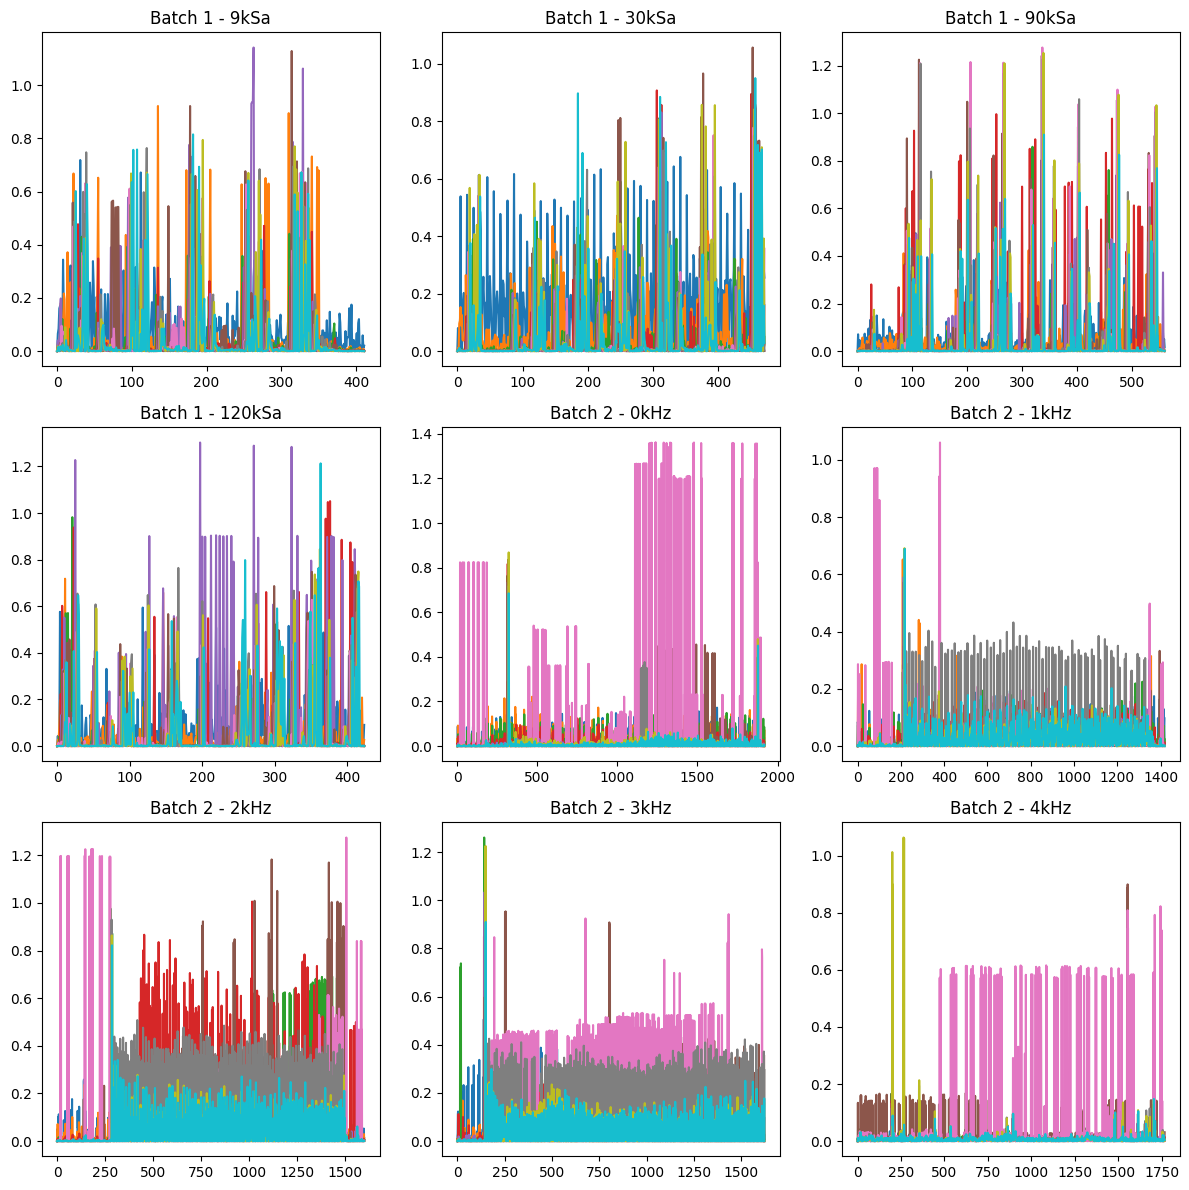

In [6]:
# Calculate velocity for each dataset

#Batch 1
velocity_df_batch1_9kSa = calculate_velocity(df_batch1_9ksa)
velocity_df_batch1_30kSa = calculate_velocity(df_batch1_30ksa)
velocity_df_batch1_90kSa = calculate_velocity(df_batch1_90ksa)
velocity_df_batch1_120kSa = calculate_velocity(df_batch1_120ksa)

# Batch 2
velocity_df_batch2_0kHz = calculate_velocity(df_batch2_0kHz)
velocity_df_batch2_1kHz = calculate_velocity(df_batch2_1kHz)
velocity_df_batch2_2kHz = calculate_velocity(df_batch2_2kHz)
velocity_df_batch2_3kHz = calculate_velocity(df_batch2_3kHz)
velocity_df_batch2_4kHz = calculate_velocity(df_batch2_4kHz)

import matplotlib.pyplot as plt

# Create a figure with 9 subplots
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Plot the velocity dataframes in each subplot
axs[0, 0].plot(velocity_df_batch1_9kSa)
axs[0, 0].set_title('Batch 1 - 9kSa')
axs[0, 1].plot(velocity_df_batch1_30kSa)
axs[0, 1].set_title('Batch 1 - 30kSa')
axs[0, 2].plot(velocity_df_batch1_90kSa)
axs[0, 2].set_title('Batch 1 - 90kSa')
axs[1, 0].plot(velocity_df_batch1_120kSa)
axs[1, 0].set_title('Batch 1 - 120kSa')
axs[1, 1].plot(velocity_df_batch2_0kHz)
axs[1, 1].set_title('Batch 2 - 0kHz')
axs[1, 2].plot(velocity_df_batch2_1kHz)
axs[1, 2].set_title('Batch 2 - 1kHz')
axs[2, 0].plot(velocity_df_batch2_2kHz)
axs[2, 0].set_title('Batch 2 - 2kHz')
axs[2, 1].plot(velocity_df_batch2_3kHz)
axs[2, 1].set_title('Batch 2 - 3kHz')
axs[2, 2].plot(velocity_df_batch2_4kHz)
axs[2, 2].set_title('Batch 2 - 4kHz')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


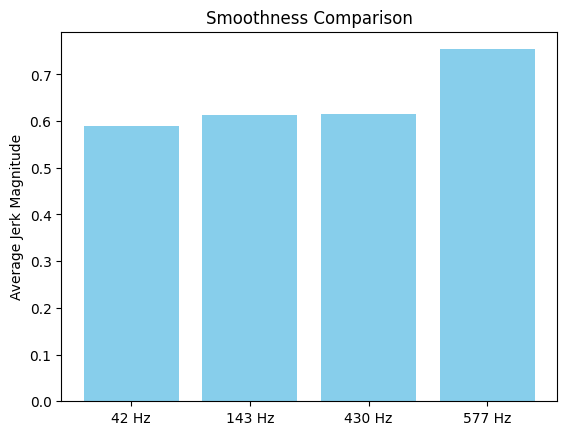

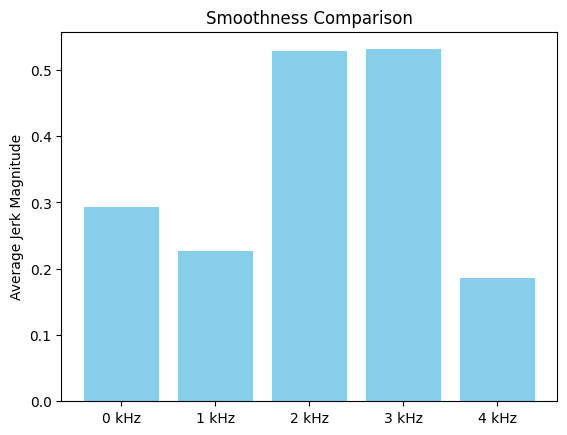

P-value for jerkiness comparison between Batch 1 and Batch 2: 0.014768874738455617
Significant difference in smoothness between Batch 1 and Batch 2.


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

def calculate_acceleration(velocity_df):
    """
    Calculate the acceleration (first derivative of velocity) for each keypoint.
    """
    return velocity_df.diff().fillna(0)

def calculate_jerk(acceleration_df):
    """
    Calculate the jerk (first derivative of acceleration) for each keypoint.
    """
    return acceleration_df.diff().fillna(0)

def compute_jerk_magnitude(jerk_df):
    """
    Compute the magnitude of jerk for each keypoint and average across all keypoints.
    """
    jerk_magnitude = np.sqrt((jerk_df**2).sum(axis=1))  # Magnitude of jerk vector
    return jerk_magnitude.mean()  # Average jerk magnitude over time

def analyze_smoothness(velocity_dfs, labels):
    """
    Calculate and plot smoothness (average jerk magnitude) for each dataset.
    """
    jerk_scores = []
    for velocity_df in velocity_dfs:
        acceleration_df = calculate_acceleration(velocity_df)
        jerk_df = calculate_jerk(acceleration_df)
        jerk_magnitude = compute_jerk_magnitude(jerk_df)
        jerk_scores.append(jerk_magnitude)

    # Plot smoothness comparison
    plt.bar(labels, jerk_scores, color='skyblue')
    plt.ylabel('Average Jerk Magnitude')
    plt.title('Smoothness Comparison')
    plt.show()

    return jerk_scores

# Batch 1 datasets
batch1_velocity_dfs = [
    velocity_df_batch1_9kSa,
    velocity_df_batch1_30kSa,
    velocity_df_batch1_90kSa,
    velocity_df_batch1_120kSa,
]
batch1_labels = ['42 Hz', '143 Hz', '430 Hz', '577 Hz']

# Batch 2 datasets
batch2_velocity_dfs = [
    velocity_df_batch2_0kHz,
    velocity_df_batch2_1kHz,
    velocity_df_batch2_2kHz,
    velocity_df_batch2_3kHz,
    velocity_df_batch2_4kHz,
]
batch2_labels = ['0 kHz', '1 kHz', '2 kHz', '3 kHz', '4 kHz']

# Calculate smoothness for Batch 1 and Batch 2
batch1_jerk_scores = analyze_smoothness(batch1_velocity_dfs, batch1_labels)
batch2_jerk_scores = analyze_smoothness(batch2_velocity_dfs, batch2_labels)

# Statistical comparison between batches
_, p_value = ttest_ind(batch1_jerk_scores, batch2_jerk_scores)
print(f"P-value for jerkiness comparison between Batch 1 and Batch 2: {p_value}")
if p_value < 0.05:
    print("Significant difference in smoothness between Batch 1 and Batch 2.")
else:
    print("No significant difference in smoothness between Batch 1 and Batch 2.")
